# Model selection statistic by data length

Paper plot using data generated by the hvblock_hyperparameter_model_selection.ipynb notebook

In [16]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arx.experiments as ex
import glob

In [17]:
infiles = glob.glob('../results/1-hard-10fold-T=100-n=10-mc=1000-seed=*.csv')
data = pd.concat([pd.read_csv(f) for f in infiles])
print(f"{len(data)} observations")
data.head()

2000 observations


,index,alpha,mA_elppd,mB_elppd,mA_eljpd,mB_eljpd,sel_elppd,sel_eljpd,mA_joint,mB_joint,sel_joint,mA_pw,mB_pw,sel_pw,T,n,mc_reps,k,seed
0,0,0.00,-173.578450,-177.194035,-173.678167,-176.748205,3.615585,3.070037,-180.050052,-181.067936,1.017884,-180.403950,-181.596579,1.192629,100,10,1000,10,7
1,0,0.50,-187.549102,-191.865556,-173.732225,-176.703593,4.316454,2.971367,-180.472437,-181.119123,0.646686,-199.843105,-202.689969,2.846864,100,10,1000,10,7
2,0,0.75,-208.738420,-211.988274,-173.838360,-176.618876,3.249855,2.780516,-182.016122,-182.655155,0.639032,-222.613278,-225.840374,3.227096,100,10,1000,10,7
3,0,1.00,-284.785453,-282.234617,-174.253673,-176.952042,-2.550835,2.698369,-189.047386,-189.029745,-0.017641,-278.025760,-276.653584,-1.372177,100,10,1000,10,7
4,1,0.00,-173.979703,-177.383109,-173.979371,-177.051939,3.403406,3.072568,-176.611412,-180.229383,3.617971,-176.130281,-179.293375,3.163094,100,10,1000,10,7


In [18]:
nrec = data[data.alpha == 0.0].shape[0]
print(f"{nrec} posteriors")

ALPHAS = jnp.array([0, 0.75, 1.0])

500 posteriors


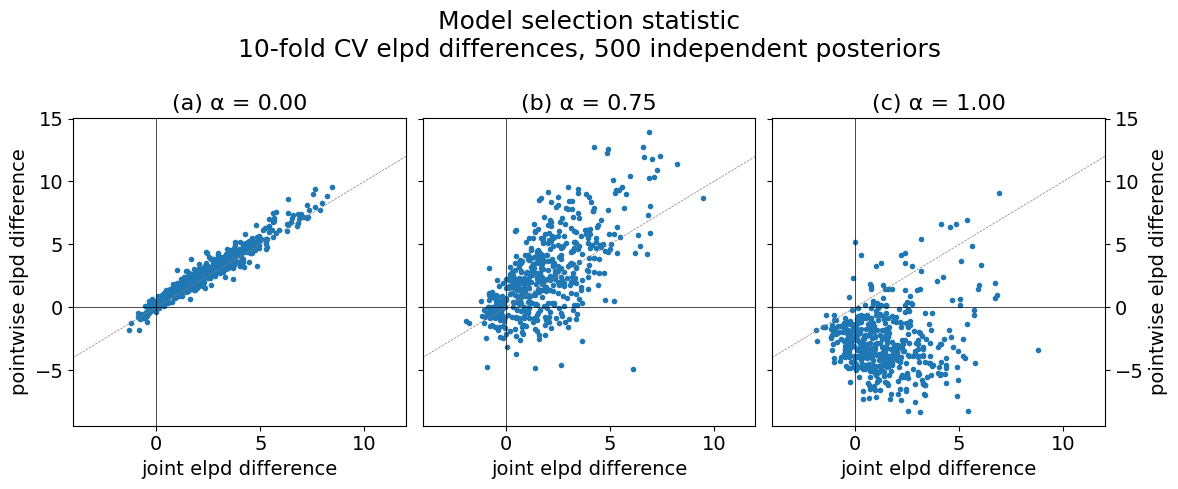

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=len(ALPHAS), figsize=(12, 5), sharey='row', sharex=True)

plt.rcParams.update({'font.size': 14})

for i, (ax, alpha) in enumerate(zip(axes, ALPHAS)):
    sel = (data.alpha == alpha)
    pl = ax.scatter(data[sel].sel_joint, data[sel].sel_pw, marker='.')
    ax.set_title(f"({chr(ord('a')+i)}) α = {alpha:.2f}", fontsize=16)
    ax.set_xlabel("joint elpd difference")
    ax.axline([0,0], [1,1], color='gray', linewidth=0.5, linestyle='--')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(min(-4, data[sel].sel_joint.min()), max(12, data[sel].sel_joint.max()))

for ax in axes[[0,-1]]:
    ax.set_ylabel("pointwise elpd difference")

rax = axes[-1]
rax.yaxis.set_label_position('right')
rax.yaxis.set_tick_params(labelright=True)
rax.yaxis.set_ticks_position('both')

fig.suptitle(f"Model selection statistic\n10-fold CV elpd differences, {nrec} independent posteriors", fontsize=18)
fig.tight_layout()
plt.subplots_adjust(wspace=.05, hspace=0)

fig.savefig("../../paper/figures/full-bayes-selection-original.svg")

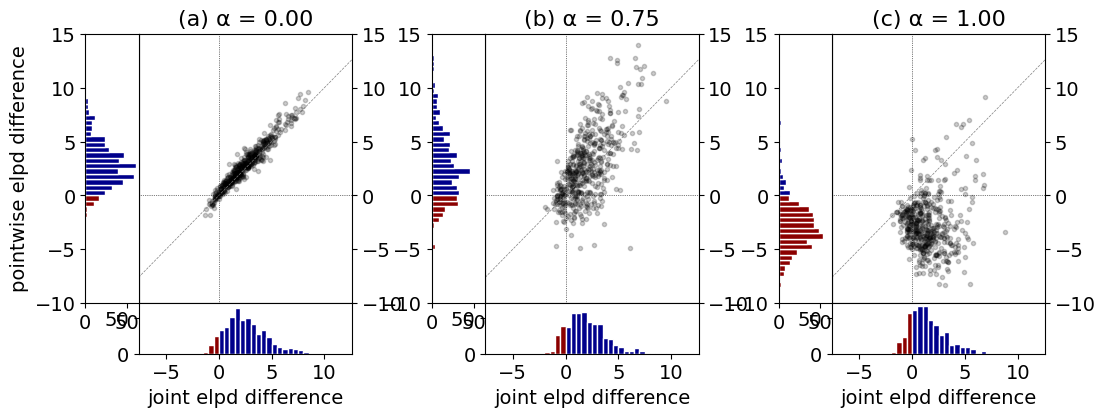

In [20]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(nrows=2, ncols=8, width_ratios=(1,4,1.5,1,4,1.5,1,4), height_ratios=(4,0.75),
    left=0.1, right=0.9, bottom=0.1, top=0.9,
    wspace=0, hspace=0)

main_ax = None
marg_ax_y, marg_ax_x = None, None

upper = np.ceil(max(data.sel_joint.max(),  data.sel_pw.max()))
lower = np.floor(min(data.sel_joint.min(),  data.sel_pw.min()))
bins = np.arange(lower, upper+1, 0.5)

for i, alpha in enumerate(ALPHAS):
    xoffset = i*3

    if main_ax is None:
        ax_cent = fig.add_subplot(gs[0, xoffset+1])
        ax_x = fig.add_subplot(gs[1, xoffset+1], sharex=ax_cent)
        ax_y = fig.add_subplot(gs[0, xoffset+0], sharey=ax_cent)
        main_ax = ax_cent
        marg_ax_y = ax_y
        marg_ax_x = ax_x
    else:
        ax_cent = fig.add_subplot(gs[0, xoffset+1], sharex=main_ax, sharey=main_ax)
        ax_x = fig.add_subplot(gs[1, xoffset+1], sharex=ax_cent, sharey=marg_ax_x)
        ax_y = fig.add_subplot(gs[0, xoffset+0], sharey=ax_cent, sharex=marg_ax_y)

    sel = (data.alpha == alpha)
    pl = ax_cent.scatter(data[sel].sel_joint, data[sel].sel_pw, marker='.', color='k', alpha=0.2)
    ny, binsy, patchesy = ax_y.hist(data[sel].sel_pw, bins=bins, orientation='horizontal', edgecolor='white', color='darkblue')
    nx, binsx, patchesx = ax_x.hist(data[sel].sel_joint, bins=bins, edgecolor='white', color='darkblue')
    for b, p in zip(binsy, patchesy):
        if b < 0:
            p.set_facecolor('darkred')
    for b, p in zip(binsx, patchesx):
        if b < 0:
            p.set_facecolor('darkred')
    ax_cent.set_title(f"({chr(ord('a')+i)}) α = {alpha:.2f}", fontsize=16)
    ax_x.set_xlabel("joint elpd difference")
    ax_cent.axline([0,0], [1,1], color='gray', linewidth=0.5, linestyle='--')
    ax_cent.axhline(0, color='k', linewidth=0.5, linestyle=':')
    ax_cent.axvline(0, color='k', linewidth=0.5, linestyle=':')
    ax_cent.set_xlim(-7.6, 12.6)
    ax_cent.set_ylim(-10, 15)
    ax_cent.xaxis.set_ticks([-5, 0, 5, 10])
    ax_cent.yaxis.tick_right()

    if i == 0:
        ax_y.set_ylabel("pointwise elpd difference")
    elif i == 2:
        ax_cent.set_ylabel("pointwise elpd difference")
        #ax_cent.yaxis.set_label_position('right')
        #ax_cent.yaxis.set_tick_params(labelright=True)
        #ax_cent.yaxis.set_ticks_position('both')

#fig.suptitle(f"Model selection statistic\n10-fold CV elpd differences, {nrec} independent posteriors", fontsize=18)
plt.subplots_adjust(wspace=0., hspace=0.)

fig.savefig("../../paper/figures/full-bayes-selection-margs-original.svg")

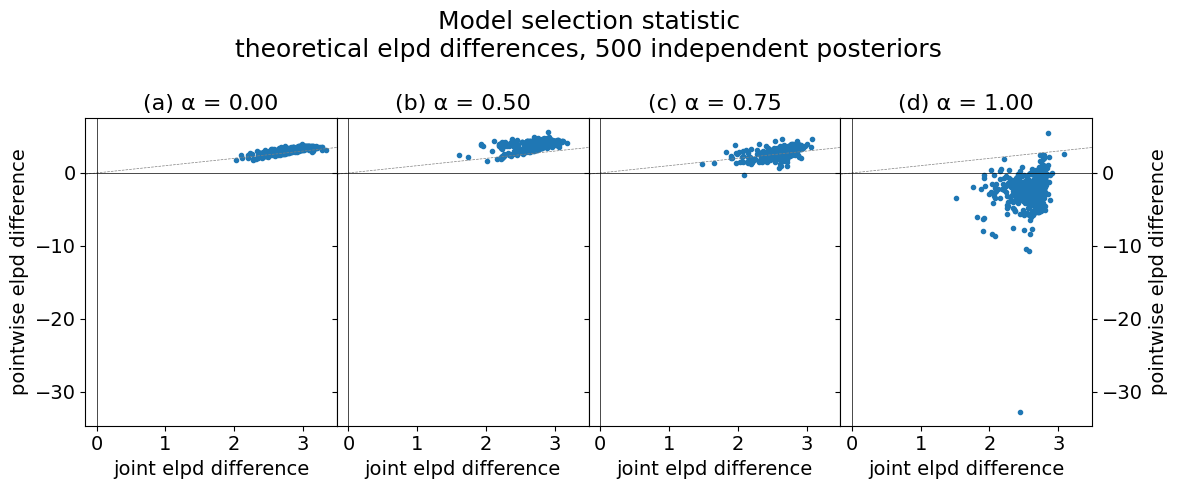

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=len(ex.ALPHA_SM), figsize=(12, 5), sharey='row', sharex=True)

plt.rcParams.update({'font.size': 14})

for i, (ax, alpha) in enumerate(zip(axes, ex.ALPHA_SM)):
    sel = (data.alpha == alpha)
    pl = ax.scatter(data[sel].sel_eljpd, data[sel].sel_elppd, marker='.')
    ax.set_title(f"({chr(ord('a')+i)}) α = {alpha:.2f}", fontsize=16)
    ax.set_xlabel("joint elpd difference")
    ax.axline([0,0], [1,1], color='gray', linewidth=0.5, linestyle='--')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)

for ax in axes[[0,-1]]:
    ax.set_ylabel("pointwise elpd difference")

rax = axes[-1]
#rax.yaxis.tick_right()
rax.yaxis.set_label_position('right')
rax.yaxis.set_tick_params(labelright=True)
rax.yaxis.set_ticks_position('both')

fig.suptitle(f"Model selection statistic\ntheoretical elpd differences, {nrec} independent posteriors", fontsize=18)
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

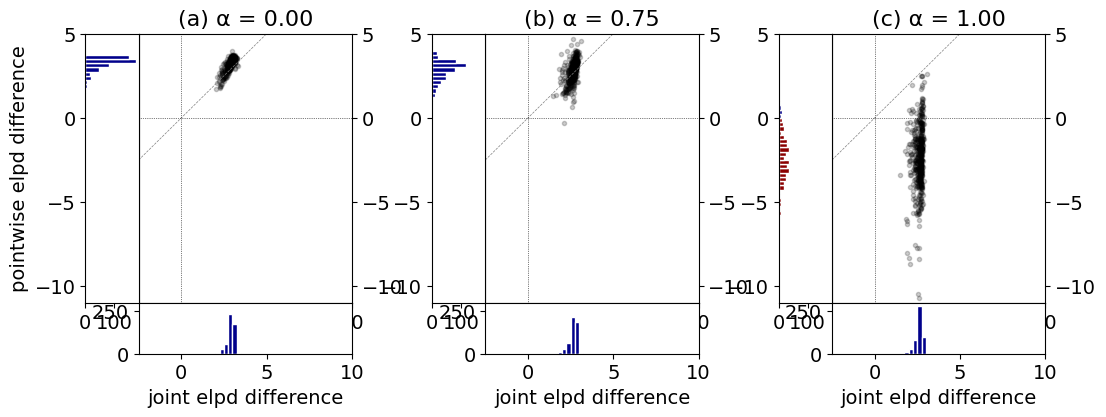

In [32]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(nrows=2, ncols=8, width_ratios=(1,4,1.5,1,4,1.5,1,4), height_ratios=(4,0.75),
    left=0.1, right=0.9, bottom=0.1, top=0.9,
    wspace=0, hspace=0)

main_ax = None
marg_ax_y, marg_ax_x = None, None

upper = np.ceil(max(data.sel_eljpd.max(),  data.sel_elppd.max()))
lower = np.floor(min(data.sel_eljpd.min(),  data.sel_elppd.min()))
bins = np.arange(lower, upper+1, 0.25)

for i, alpha in enumerate(ALPHAS):
    xoffset = i*3

    if main_ax is None:
        ax_cent = fig.add_subplot(gs[0, xoffset+1])
        ax_x = fig.add_subplot(gs[1, xoffset+1], sharex=ax_cent)
        ax_y = fig.add_subplot(gs[0, xoffset+0], sharey=ax_cent)
        main_ax = ax_cent
        marg_ax_y = ax_y
        marg_ax_x = ax_x
    else:
        ax_cent = fig.add_subplot(gs[0, xoffset+1], sharex=main_ax, sharey=main_ax)
        ax_x = fig.add_subplot(gs[1, xoffset+1], sharex=ax_cent, sharey=marg_ax_x)
        ax_y = fig.add_subplot(gs[0, xoffset+0], sharey=ax_cent, sharex=marg_ax_y)

    sel = (data.alpha == alpha)
    pl = ax_cent.scatter(data[sel].sel_eljpd, data[sel].sel_elppd, marker='.', color='k', alpha=0.2)
    ny, binsy, patchesy = ax_y.hist(data[sel].sel_elppd, bins=bins, orientation='horizontal', edgecolor='white', color='darkblue')
    nx, binsx, patchesx = ax_x.hist(data[sel].sel_eljpd, bins=bins, edgecolor='white', color='darkblue')
    for b, p in zip(binsy, patchesy):
        if b < 0:
            p.set_facecolor('darkred')
    for b, p in zip(binsx, patchesx):
        if b < 0:
            p.set_facecolor('darkred')
    ax_cent.set_title(f"({chr(ord('a')+i)}) α = {alpha:.2f}", fontsize=16)
    ax_x.set_xlabel("joint elpd difference")
    ax_cent.axline([0,0], [1,1], color='gray', linewidth=0.5, linestyle='--')
    ax_cent.axhline(0, color='k', linewidth=0.5, linestyle=':')
    ax_cent.axvline(0, color='k', linewidth=0.5, linestyle=':')
    ax_cent.set_xlim(-2.5, 8)
    ax_cent.xaxis.set_ticks([0., 5., 10.])
    ax_cent.set_ylim(-11, 5)
    ax_cent.yaxis.tick_right()

    if i == 0:
        ax_y.set_ylabel("pointwise elpd difference")
    elif i == 2:
        ax_cent.set_ylabel("pointwise elpd difference")

plt.subplots_adjust(wspace=0., hspace=0.)

fig.savefig("../../paper/figures/full-bayes-selection-theoretical-margs-original.svg")